In [1]:
import sys
import os

# Add ROOT/model path to load own modules
model_path = os.path.normpath(os.path.join(os.getcwd(), *[os.pardir]*2, "model"))
sys.path.insert(0, model_path)

In [2]:
import rasterio
import rasterio.plot 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# for aggegating raster values with shapefiles
from rasterio.mask import mask
import geopandas as gpd
from shapely.geometry import mapping

# To get lon/lat coordinates
import xarray as xr
from rasterio.warp import transform

# To make predictions
import tensorflow as tf

from utils import ROOT_DIR

from IPython.display import display, Markdown

%matplotlib inline

<br><br><br>
# Definitions

In [3]:
def get_lon_lat_coordinates(filepath=ROOT_DIR + "/data/features/pop.tif"):
    # Code comes from http://xarray.pydata.org/en/v0.10.0/auto_gallery/plot_rasterio.html
    
    # Read the data
    da = xr.open_rasterio(filepath)

    # Compute the lon/lat coordinates with rasterio.warp.transform
    ny, nx = len(da['y']), len(da['x'])
    x, y = np.meshgrid(da['x'], da['y'])

    # Rasterio works with 1D arrays
    lon, lat = transform(da.crs, {'init': 'EPSG:4326'},
                         x.flatten(), y.flatten())

    lon = np.asarray(lon).reshape((ny, nx))
    lat = np.asarray(lat).reshape((ny, nx))
    
    lon_1d_array = lon.reshape(-1)
    lat_1d_array = lat.reshape(-1)
    
    # arrays with with shapes (849, 1469) transormed to array with shape (849*1469,)
    return lon_1d_array, lat_1d_array
    #da.coords['lon'] = (('y', 'x'), lon)
    #da.coords['lat'] = (('y', 'x'), lat)

In [4]:
def read_raster_file(filepath):
        # read raster data band1 from the .tif file
        raster_open = rasterio.open(filepath)
        raster_data = raster_open.read(1)
        raster_data_1d_array = raster_data.reshape(-1)

        # raster data defines -3.4e+38 as the value, when data is missing
        raster_na_value = np.float32(raster_open.nodata)
        raster_open.close()
        
        return raster_data_1d_array, raster_na_value

In [5]:
def get_featureData():
    featureData = pd.DataFrame()
    # pop_non_scaled is not used for prediction, but only for getting total_cases from adj_cases
    featureTifs = ["access", "pet", "pop", "urban", "W_access", "pop_non_scaled"]
    shape = (849, 1469)
    # Initiliase
    raster_na_value = None

    # get longitude and latitude
    lon_1d_array, lat_1d_array = get_lon_lat_coordinates(ROOT_DIR + "/data/features/{}.tif".format(featureTifs[0]))
    featureData["longitude"] = lon_1d_array
    featureData["latitude"] = lat_1d_array

    for feature in featureTifs:
        filepath = ROOT_DIR + "/data/features/{}.tif".format(feature)
        raster_data_1d_array, raster_na_value = read_raster_file(filepath)
        featureData[feature] = raster_data_1d_array
            
    return featureData, raster_na_value, shape

In [6]:
def get_predictions(cleanedFeatureData, modelPath):
    model = tf.keras.models.load_model(modelPath)
    
    # drop pop_non_scaled column, because it is not used for predictions, but only for getting total_cases from adj_cases
    data = cleanedFeatureData.copy().drop(columns="pop_non_scaled")
    # Normalize data as by training
    data["longitude"] = data["longitude"] / 180
    data["latitude"] = data["latitude"] / 90
    
    predictions = model.predict(data.values, batch_size=32)
    return predictions

In [7]:
def prepare_predictions(predictions):
    # make predictions always 1d array
    predictions = predictions.reshape(-1)
    # # set negative predicted values to zero, because values should not be < 0
    #predictions[predictions < 0] = 0
    return predictions

In [8]:
def reshape_to_raster(array1D, raster_shape):
    return array1D.reshape(raster_shape)

In [9]:
def get_raster_data(featureData, cleanedFeatureData, adj_log_predictions, raster_na_value, raster_shape): 
    labels = pd.DataFrame(index=cleanedFeatureData.index)
    labels["adj_cases_log"] = prepare_predictions(adj_cases_log_predictions.copy())
    # adj_cases_log is log(adj_cases + 1)
    # Therefore adj_cases backwards is (exp(adj_cases_log) - 1)
    labels["adj_cases"] = np.exp(labels["adj_cases_log"]) - 1
    # Calculate total cases by inverting the formula of adj_cases = (total_cases / pop_non_scaled) * 100,000
    # np.float32() is needed to make the results np.float32 type, as default it returns np.float64 which causes bugs in the code
    labels["total_cases"] = np.float32(np.multiply(labels["adj_cases"].values, cleanedFeatureData["pop_non_scaled"].values) / 100000)
    
    # logarithmic total cases to make it easier to see patterns
    labels["total_cases_log"] = np.log(labels["total_cases"].values + 1)
    
    
    # Test label data types to avoid saving bugs
    assert labels["adj_cases_log"].dtype == np.float32, "'adj_cases_log' values should be of type numpy.float32"
    assert labels["adj_cases"].dtype == np.float32, "'adj_cases' values should be of type numpy.float32"
    assert labels["total_cases"].dtype == np.float32, "'total_cases' values should be of type numpy.float32"
    assert labels["total_cases_log"].dtype == np.float32, "'total_cases_log' values should be of type numpy.float32"
    
    # fill not assigned label rows with raster_na_value
    # So are all NA values from prior raster_data masked
    labels = labels.reindex(featureData.index, fill_value=raster_na_value)
    
    return {"adj_cases_log": reshape_to_raster(labels["adj_cases_log"].values, raster_shape), 
            "adj_cases": reshape_to_raster(labels["adj_cases"].values, raster_shape),
            "total_cases": reshape_to_raster(labels["total_cases"].values, raster_shape),
            "total_cases_log": reshape_to_raster(labels["total_cases_log"].values, raster_shape)}


In [10]:
def save_raster(raster_data=None, file_name=None):
    filepath = ROOT_DIR + "/data/features/{}.tif".format("access")
    # read raster data band1 from the .tif file

    adj_cases_raster_opened = rasterio.open(filepath)
    adj_cases_raster = rasterio.open(
         ROOT_DIR + "/data/predictions/{}.tif".format(file_name),
         'w',
         driver='GTiff',
         height=raster_data.shape[0],
         width=raster_data.shape[1],
         count=1,
         dtype=raster_data.dtype,
         crs=adj_cases_raster_opened.crs,
         transform=adj_cases_raster_opened.transform,
         nodata=raster_na_value
    )
    
    assert raster_data.shape == shape, "raster_data should have shape {} to save it properly as a .tif file".format(shape)
    
    adj_cases_raster.write(raster_data, 1)
    adj_cases_raster.close()

In [11]:
def plot_rasters(raster_array, title, file_name, save=False):
    display(Markdown('## <center>Raster map of {}</center>'.format(title)))
    raster_array = raster_array.copy()
    raster_array[raster_array == raster_na_value] = np.nan
    plt.figure(figsize = (20, 10))
    im = plt.imshow(raster_array, cmap="hot")
    cb = plt.colorbar(im, pad=0.02)
    cb.ax.tick_params(labelsize=25)
    # Disable axis and their borders
    plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig(ROOT_DIR + "/data/predictions/colored/{}.jpg".format(file_name), dpi=200, bbox_inches='tight')

In [12]:
def save_raster_aggregated_shapefile(file_name, raster_file_names, column):
    shapefile = gpd.read_file(ROOT_DIR + "/data/shapefiles/China.shp")
    
    for column_index, raster_file_name in enumerate(raster_file_names):
        column_name = column[column_index]["name"]
        column_type = column[column_index]["type"]
        # add adj_cases column with empty values to shapefile DataFrame
        shapefile.insert(loc=column_index, column=column_name, value=np.nan)

        # extract the raster values within the polygon
        with rasterio.open(ROOT_DIR + "/data/predictions/{}.tif".format(raster_file_name)) as src:
            for index, shape in enumerate(shapefile["geometry"]):
                # transform to GeJSON format
                geoms = [mapping(shape)]
                out_image, out_transform = mask(src, geoms, crop=True)
                # change nodata values to nan
                out_image[out_image == np.float32(src.nodata)] = np.nan
                if column_type is "rate":
                    shapefile.loc[index, column_name] = np.nanmean(out_image)
                elif column_type is "frequency":
                    shapefile.loc[index, column_name] = np.nansum(out_image)

    # Save modified Shapefile
    shapefile.to_file(ROOT_DIR + "/data/predictions/shapefiles/{}.shp".format(file_name), driver='ESRI Shapefile')

In [13]:
def get_province_data(JHU_file_path, predictions_shapefile_path):
    JHU_data_mar = pd.read_csv(JHU_file_path)
    predictions_shapefile = gpd.read_file(predictions_shapefile_path)

    JHU_cases = np.array([JHU_data_mar.loc[JHU_data_mar["uniqu_d"] == val]["cases"].values for val in predictions_shapefile["uniqu_d"]]).reshape(-1)

    predictions_shapefile.insert(3, "JHU_cases", JHU_cases)
    predictions_shapefile.insert(4, "differences", predictions_shapefile["JHU_cases"] - predictions_shapefile["total"])

    predicted_with_JHU = predictions_shapefile[["geometry", "uniqu_d", "admin", "total", "JHU_cases", "differences"]]
    predicted_with_JHU_without_hubei = predicted_with_JHU.loc[predicted_with_JHU["uniqu_d"] != "Hubei"]
    
    return predicted_with_JHU, predicted_with_JHU_without_hubei

In [14]:
def plot_shapefile_map(data, column_name, title, color="viridis", vmin=None, vmax=None, figsize=(20, 10), save=False):
    display(Markdown('## <center>{}</center>'.format(title)))
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    data.plot(column=column_name, ax=ax, legend=True, cmap=color, vmin=vmin, vmax=vmax, edgecolor="black", legend_kwds={"pad": 0.0})
    # Change colorbar labelsize
    fig.get_axes()[-1].tick_params(labelsize=25)
    # Set Background color
    #ax.patch.set_facecolor("black")
    # Disable axis and their borders
    ax.axis("off")
    # Disable ticks
    #plt.xticks([], [])
    #plt.yticks([], [])
    plt.tight_layout()
    if save:
        plt.savefig(ROOT_DIR + "/data/predictions/shapefiles/plots/{}.jpg".format(column_name), dpi=200, bbox_inches='tight')
        

In [15]:
def plot_JHU_vs_predictions_bar(data, title="JHU cases vs. predicted cases", ymin_1=None, ymax_1=None, ymin_2=None, ymax_2=None):
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(30, 16))
    x = np.arange(len(data["uniqu_d"]))
    width = 0.35
    axs[0].bar(x - width/2, data["JHU_cases"], width=width, label="JHU cases",)
    axs[0].bar(x + width/2, data["total"], width=width, label="predicted cases")
    axs[0].set_title(title, fontdict={"fontsize": 50}, pad=30)
    axs[0].legend(fontsize=20)
    axs[0].set_xticks(x)
    axs[0].set_xticklabels(data["uniqu_d"])
    axs[0].tick_params(axis="x", labelrotation=45, labelsize=20)
    axs[0].tick_params(axis="y", labelsize=20)
    axs[0].set_ylabel(ylabel="Number of cases", fontsize=30, labelpad=20)
    axs[0].set_ylim(ymin=ymin_1, ymax=ymax_1)

    # differences plot
    bar_color = np.where(data["differences"].values>0,'b','r').T
    axs[1].bar(data["uniqu_d"], data["differences"], color=bar_color, alpha=0.6)
    axs[1].tick_params(axis="x", labelrotation=45, labelsize=20)
    axs[1].tick_params(axis="y", labelsize=20)
    axs[1].set_ylabel(ylabel="JHU cases - predicted cases", fontsize=30, labelpad=20)
    axs[1].set_ylim(ymin=ymin_2, ymax=ymax_2)
    plt.tight_layout()

In [16]:
CONFIGS = {
    "one_hidden_layer": {
        "model_path": ROOT_DIR + "/best-models/one-hidden-layer-2",
        "raster_file_name": {
            "adj_cases_log": "adj_cases_log_h1",
            "adj_cases": "adj_cases_h1",
            "total_cases": "total_cases_h1",
            "total_cases_log": "total_cases_log_h1"
        },
        "shapefile": {
            "file_name": "cases_h1",
            "raster_file_names": ["adj_cases_h1", "total_cases_h1"],
            "column": [{"name": "adj", "type": "rate"}, 
                       {"name": "total", "type": "frequency"}] # column names must be less than 10 characters
        }
    },
    "two_hidden_layers": {
        "model_path": ROOT_DIR + "/best-models/two-hidden-layers-2",
        "raster_file_name": {
            "adj_cases_log": "adj_cases_log_h2",
            "adj_cases": "adj_cases_h2",
            "total_cases": "total_cases_h2",
            "total_cases_log": "total_cases_log_h2"
        },
        "shapefile": {
            "file_name": "cases_h2",
            "raster_file_names": ["adj_cases_h2", "total_cases_h2"],
            "column": [{"name": "adj", "type": "rate"}, 
                       {"name": "total", "type": "frequency"}] # column names must be less than 10 characters
        }
    }
}

<br><br><br>
# Generate Raster Maps and Shapefiles

In [17]:
# change value to generate raster and shape files for one or two hidden layer models
CURRENT_CONFIG = CONFIGS["one_hidden_layer"]

In [18]:
featureData, raster_na_value, shape = get_featureData()
#featureData.to_csv(ROOT_DIR + "/data/features/features.csv", index=True, index_label="index", na_rep="NA")

In [19]:
cleanedFeatureData = featureData.replace(raster_na_value,np.nan).dropna()
#cleanedFeatureData.to_csv(ROOT_DIR + "/data/features/cleaned-features.csv", index=True, index_label="index", na_rep="NA")

In [20]:
# predictions takes longer, because there are about 0.5M Datapoints
adj_cases_log_predictions = get_predictions(cleanedFeatureData, 
                                            CURRENT_CONFIG["model_path"])

In [21]:
# Takes longer to predict 0.5M Datapoints
raster_data = get_raster_data(featureData, 
                              cleanedFeatureData, 
                              adj_cases_log_predictions,
                              raster_na_value,
                              shape)

In [22]:
for label_name in ["adj_cases_log", "adj_cases", "total_cases_log", "total_cases"]:
    # Save raster file for the label
    save_raster(raster_data=raster_data[label_name], 
                file_name=CURRENT_CONFIG["raster_file_name"][label_name])
    
# Aggregate raster values by China's shapefile and save new shapefile
save_raster_aggregated_shapefile(file_name=CURRENT_CONFIG['shapefile']["file_name"],
                                raster_file_names=CURRENT_CONFIG['shapefile']["raster_file_names"],
                                column=CURRENT_CONFIG['shapefile']["column"])

<br><br><br>
# Visualisations

## <center>Raster map of adj_cases_log</center>

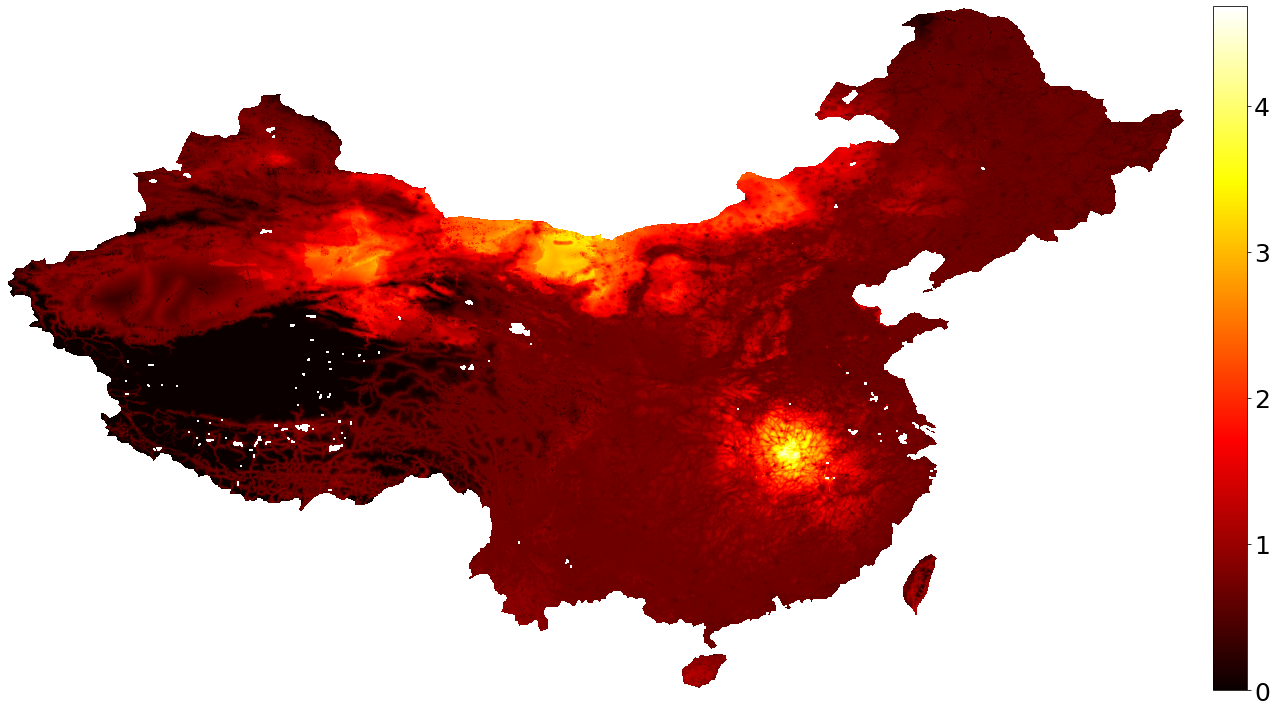

In [23]:
plot_rasters(raster_array=raster_data["adj_cases_log"],
             title="adj_cases_log",
             file_name=CURRENT_CONFIG["raster_file_name"]["adj_cases_log"],
             save=True)

## <center>Raster map of adj_cases</center>

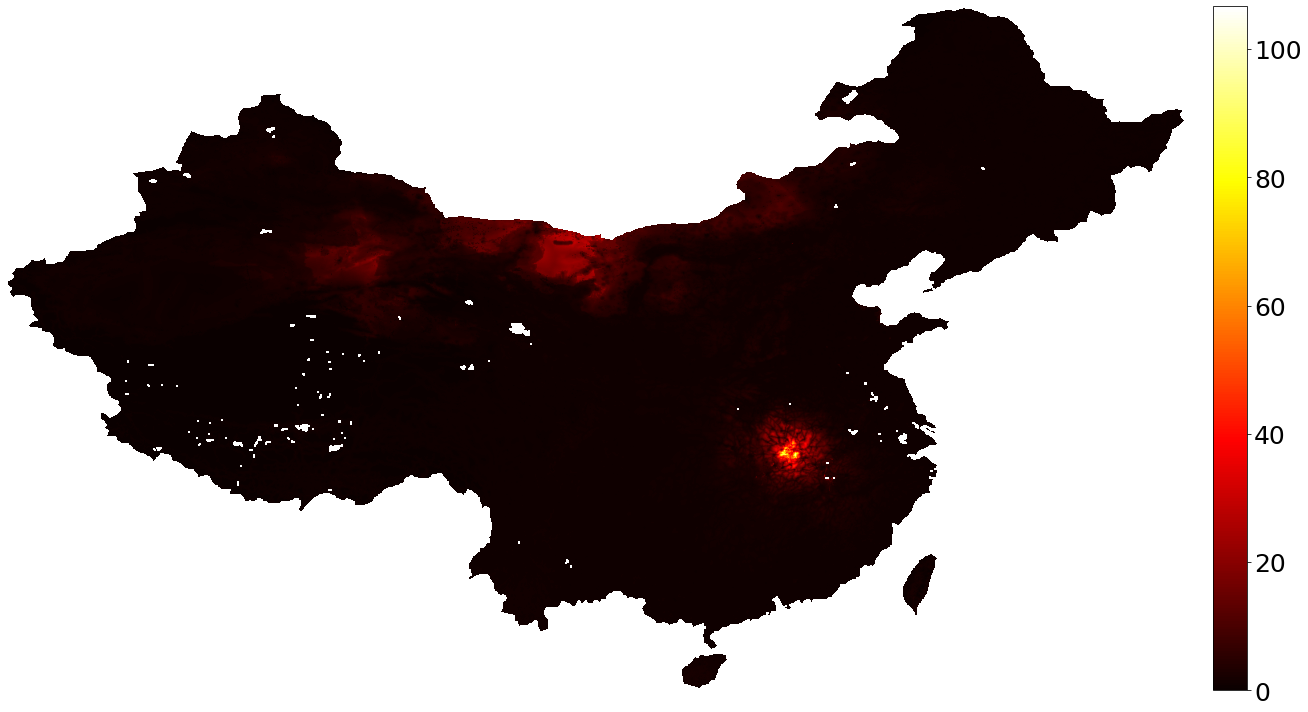

In [24]:
plot_rasters(raster_array=raster_data["adj_cases"],
             title="adj_cases",
             file_name=CURRENT_CONFIG["raster_file_name"]["adj_cases"],
             save=True)

## <center>Raster map of total_cases_log</center>

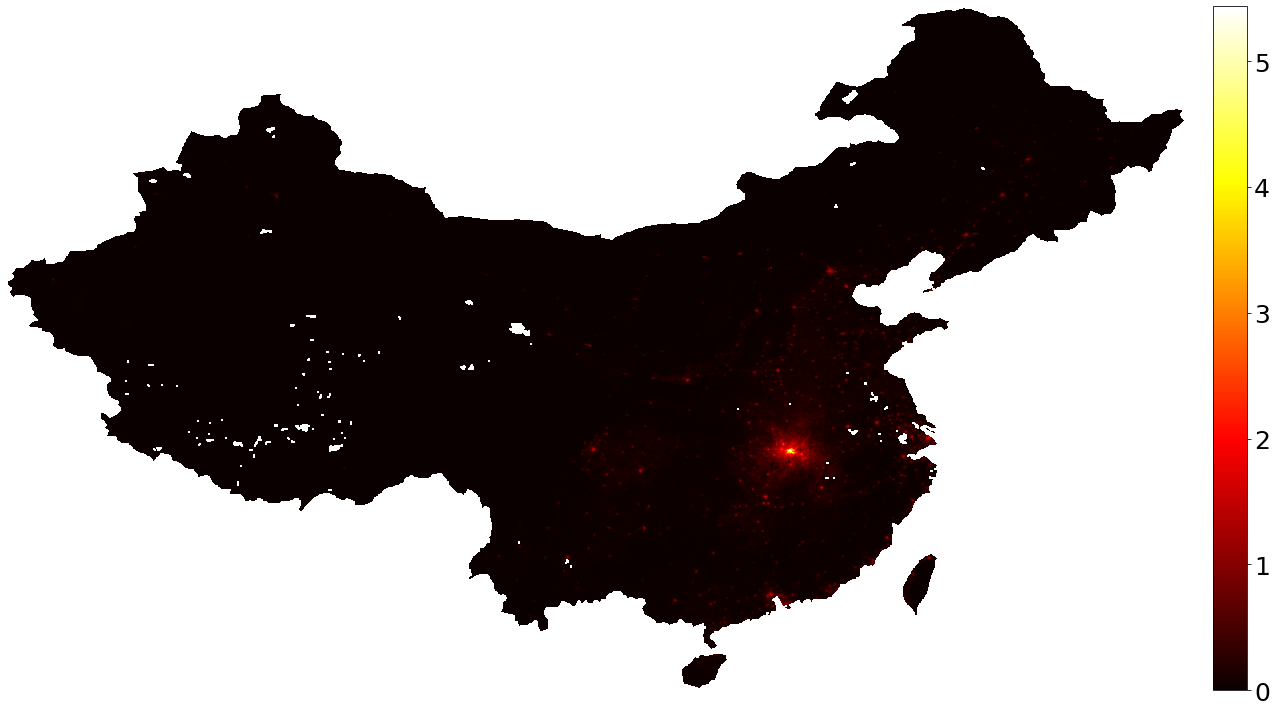

In [25]:
plot_rasters(raster_array=raster_data["total_cases_log"],
             title="total_cases_log",
             file_name=CURRENT_CONFIG["raster_file_name"]["total_cases_log"],
             save=True)

## <center>Raster map of total_cases</center>

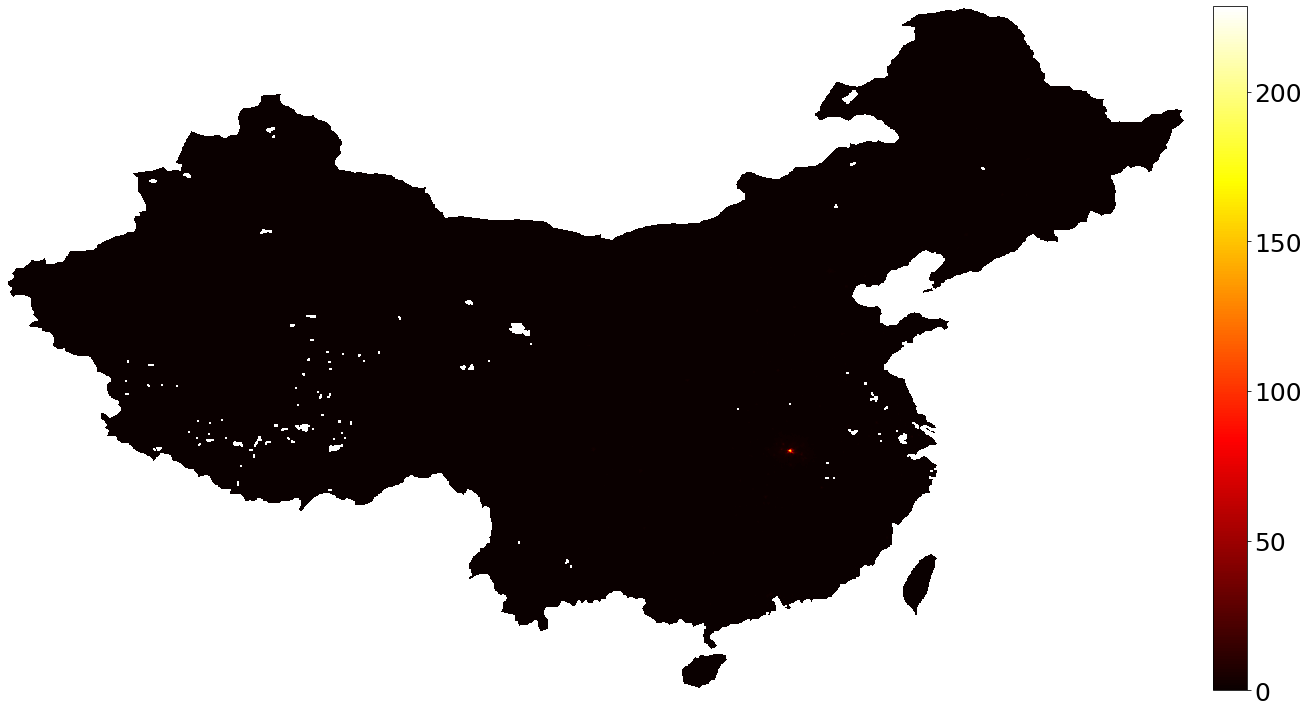

In [26]:
plot_rasters(raster_array=raster_data["total_cases"],
             title="total_cases",
             file_name=CURRENT_CONFIG["raster_file_name"]["total_cases"],
             save=True)

In [27]:
predicted_with_JHU, predicted_with_JHU_without_hubei = get_province_data(JHU_file_path=ROOT_DIR + "/data/csvs/JHU/JHUJanMar.csv", predictions_shapefile_path=ROOT_DIR + "/data/predictions/shapefiles/cases_h2.shp")

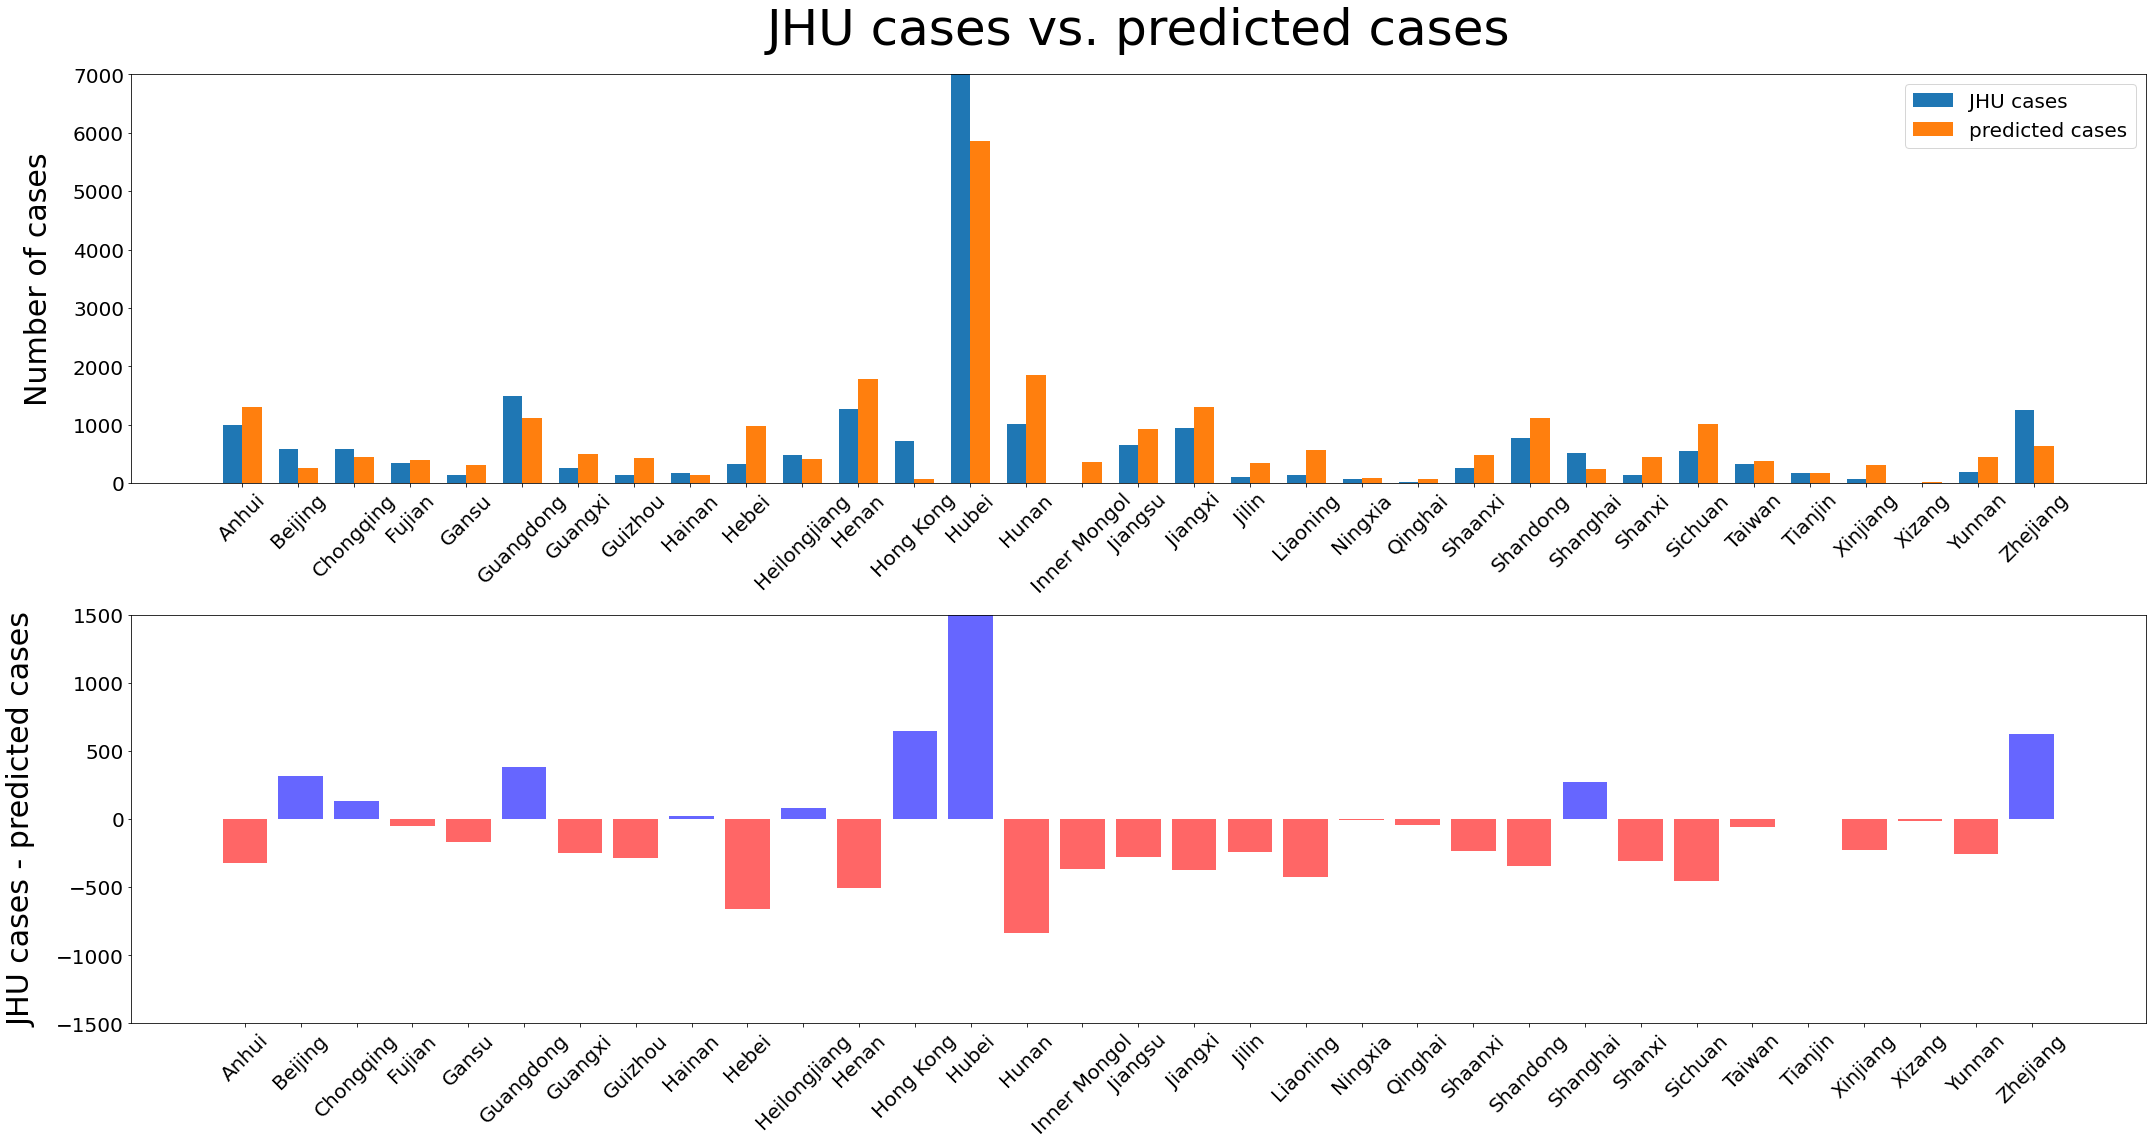

In [28]:
plot_JHU_vs_predictions_bar(predicted_with_JHU, ymin_1=0, ymax_1=7000, ymin_2=-1500, ymax_2=1500)

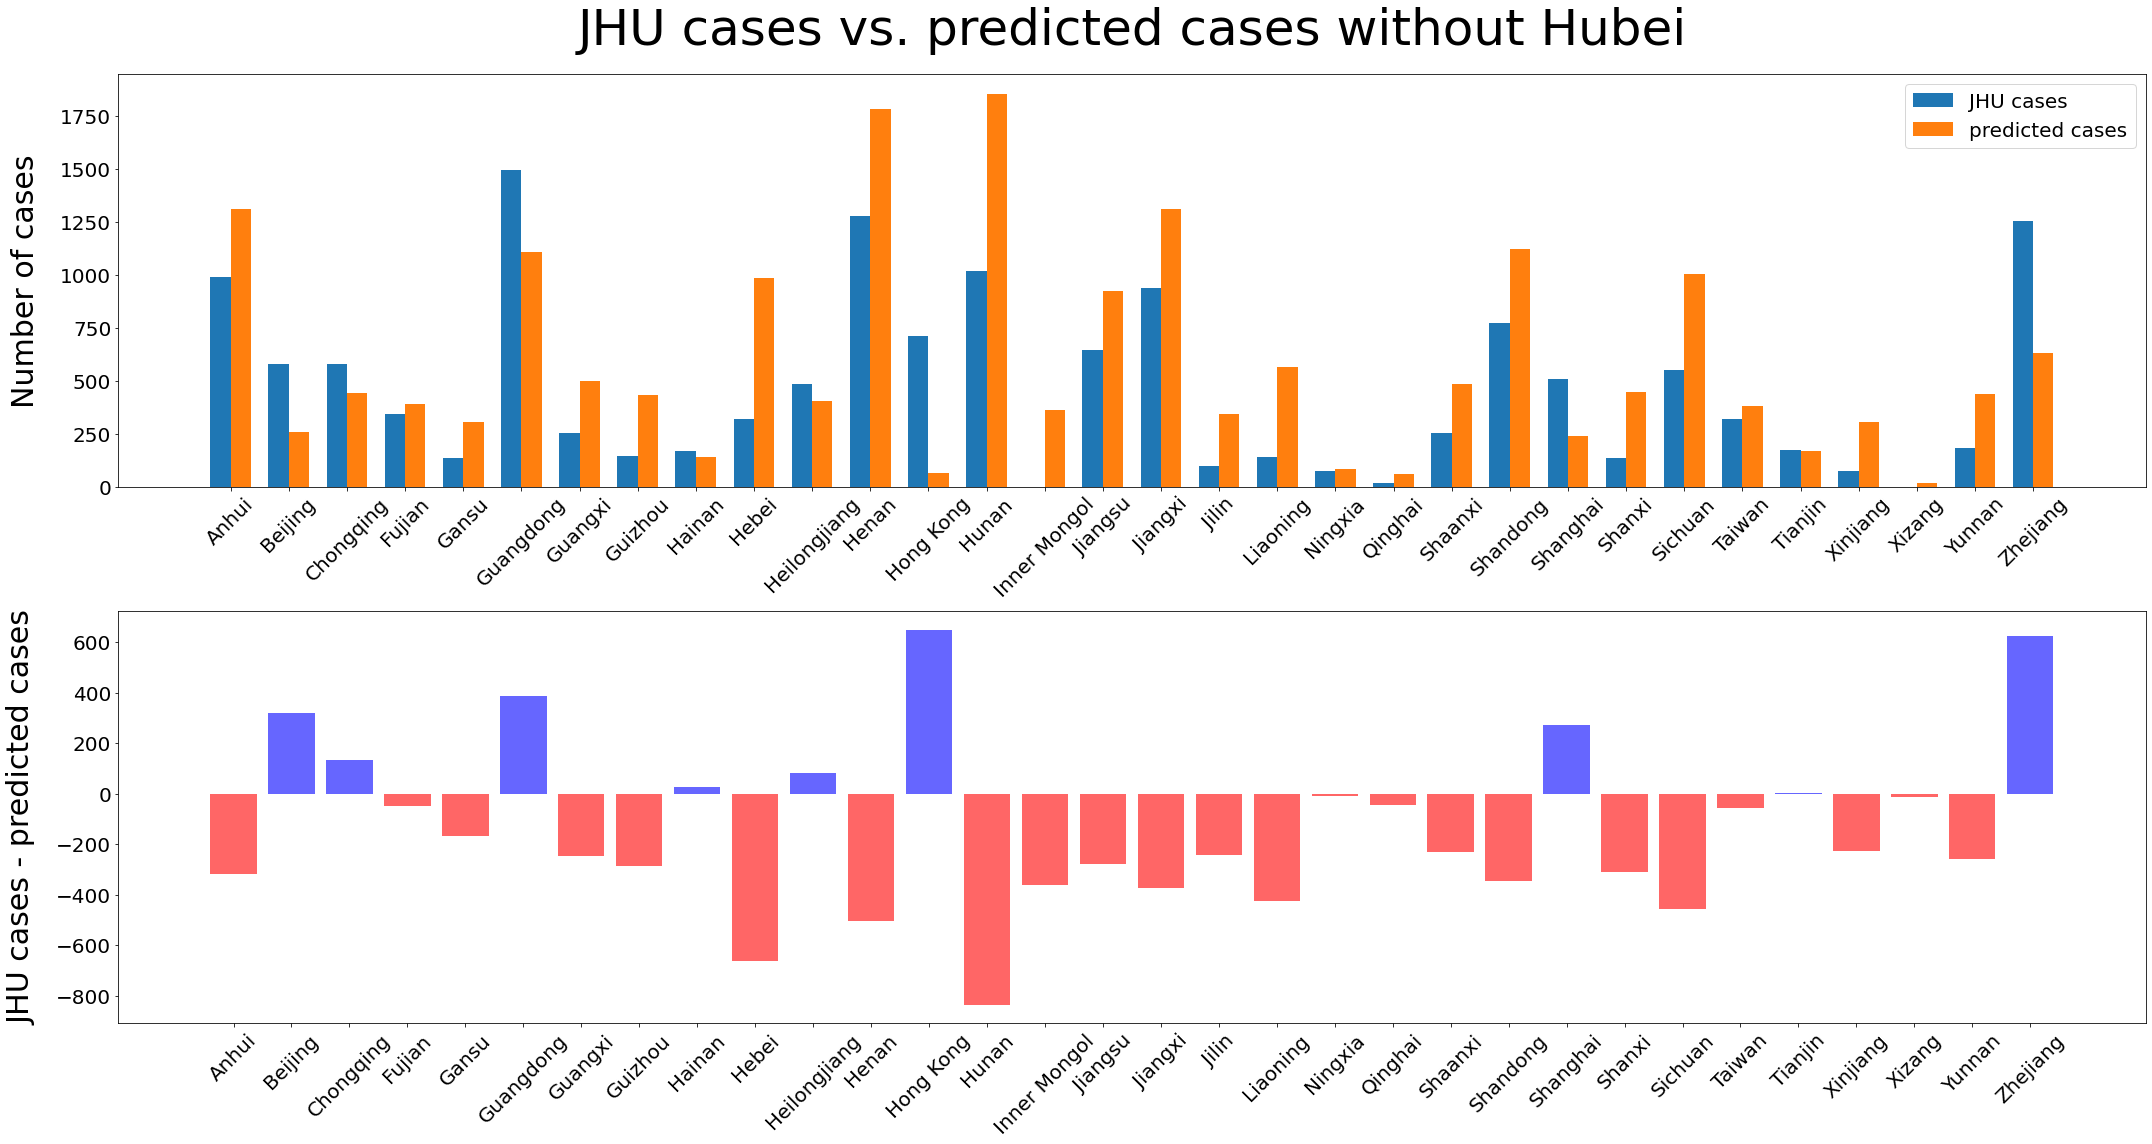

In [29]:
plot_JHU_vs_predictions_bar(predicted_with_JHU_without_hubei, title="JHU cases vs. predicted cases without Hubei")

## <center>Total cases</center>

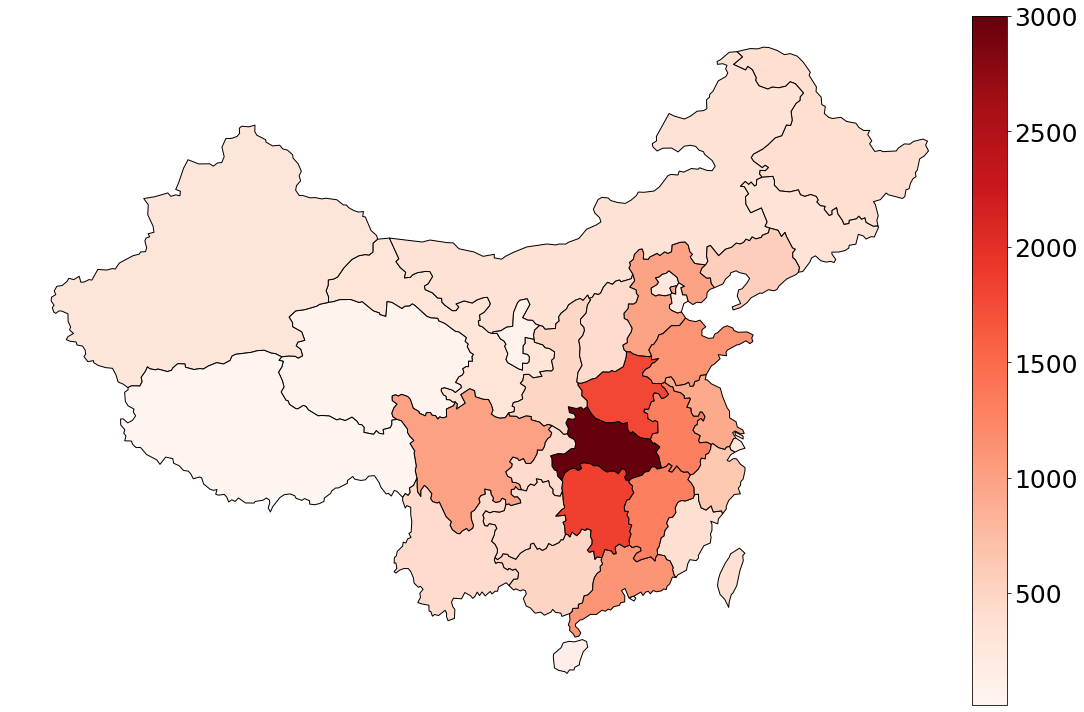

In [30]:
plot_shapefile_map(data=predicted_with_JHU, 
                   column_name="total",
                   title="Total cases",
                   color="Reds",
                   vmax=3000,
                   save=True)

## <center>JHU cases</center>

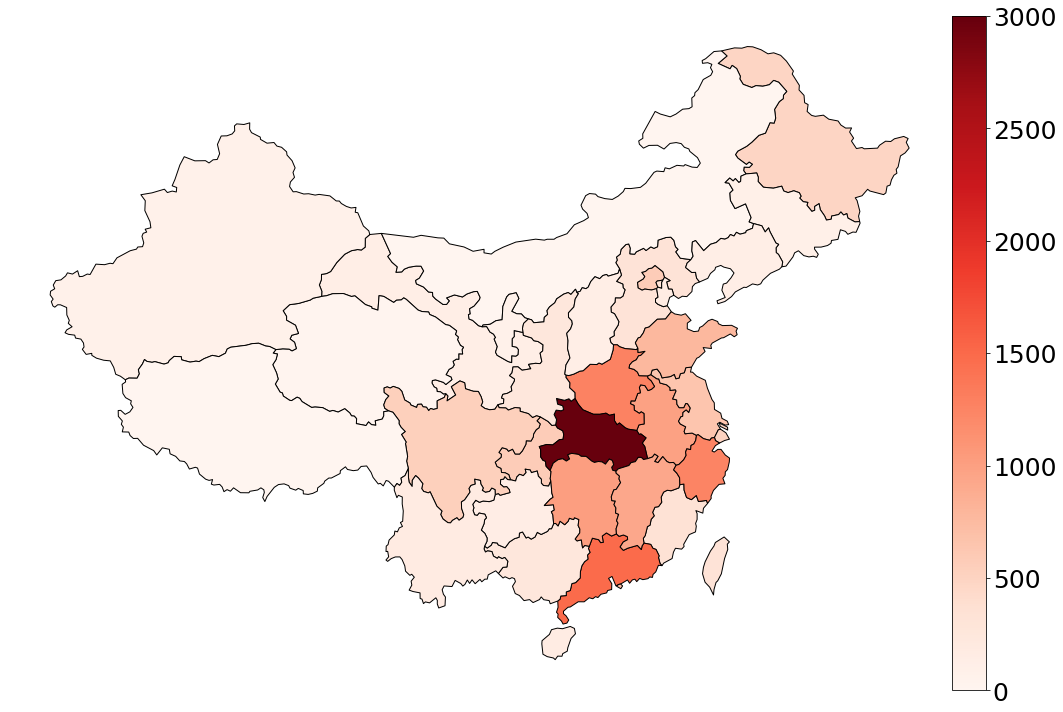

In [31]:
plot_shapefile_map(data=predicted_with_JHU, 
                   column_name="JHU_cases",
                   title="JHU cases",
                   color="Reds",
                   vmax=3000,
                   save=True)

## <center>JHU cases - predicted cases</center>

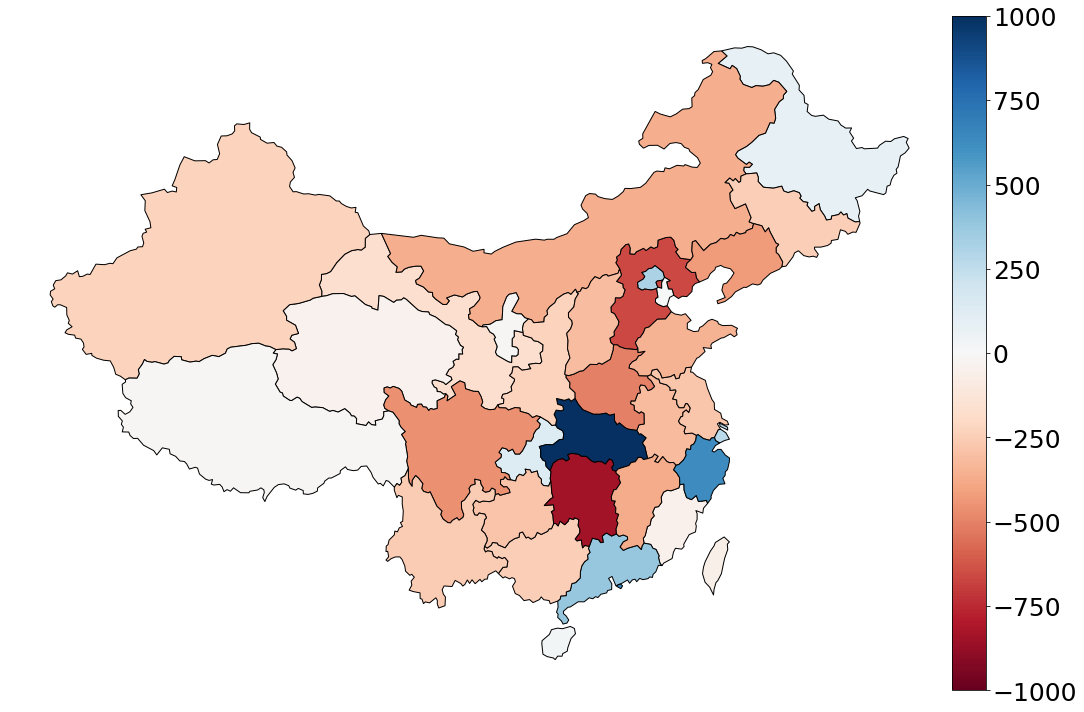

In [32]:
plot_shapefile_map(data=predicted_with_JHU,
         column_name="differences",
         title="JHU cases - predicted cases",
         color="RdBu",
         vmin=-1000,
         vmax=1000,
         save=True)